In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
from slam.utils.visualize import plotMatrix

%matplotlib widget

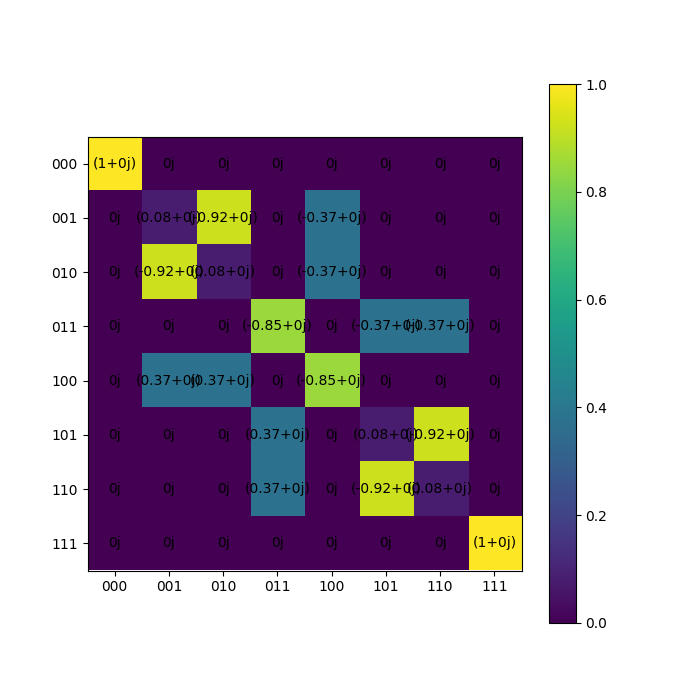

In [3]:
#using our same metrics as before using ratio of coupling strengths, investigate the relative costs of our 3Q gates
from slam.hamiltonian import CirculatorHamiltonian
#v_nn = np.sqrt(2) * np.pi / np.arccos(1 / np.sqrt(3)) #w-state
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0]
#v_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / v_nn, np.pi / v_nn, np.pi / v_nn]
_array = CirculatorHamiltonian.construct_U(*v_params,t=1.6442677715360021) #w-state
#_array = CirculatorHamiltonian.construct_U(*v_params,t=1) #completed DIV
plotMatrix(_array);

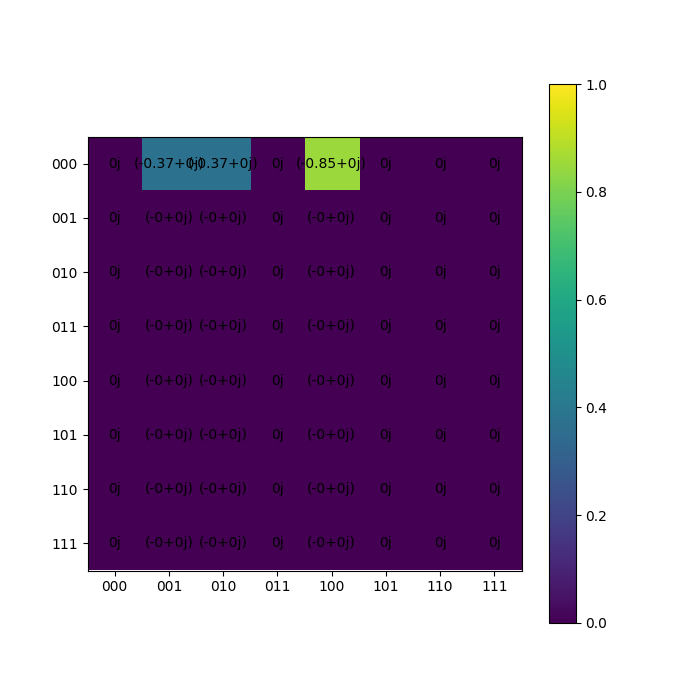

In [4]:
output_state = np.matmul(_array.full(),np.array([0,0,0,0,1,0,0,0]))
plotMatrix(output_state * [[1],[0],[0],[0],[0],[0],[0],[0]]);

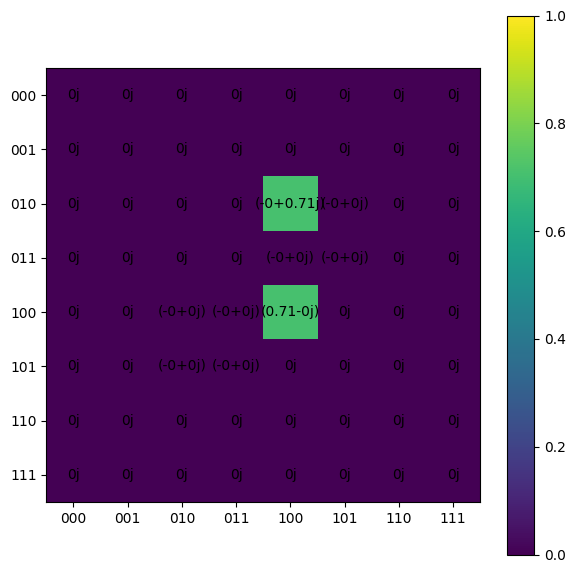

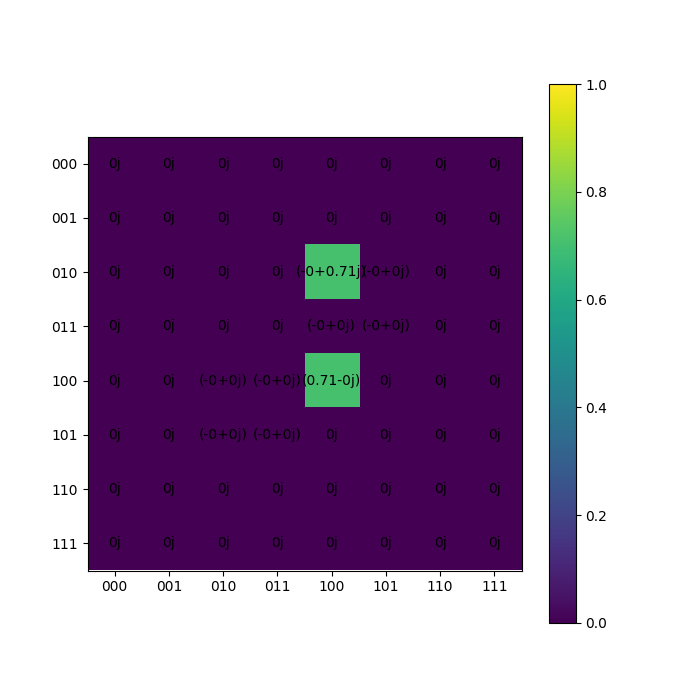

In [5]:
from qiskit.circuit.library.standard_gates import iSwapGate, IGate
from qiskit.quantum_info import Operator
s = Operator(iSwapGate().power(1/2)).tensor(Operator(IGate())).data * [0,0,0,0,1,0,0,0]
from qiskit import QuantumCircuit
qc = QuantumCircuit(3)
qc.append(iSwapGate(), [0,2])
s2 = Operator(qc).data * s
plotMatrix(s)

In [6]:
1.4142135623730951 * 0.6081734479693927

0.860087138393523

In [7]:
2/np.sqrt(2) * (np.pi/2) / (2*np.pi / v_nn)

1.0

In [8]:
#consider V-swap on |100> -> [|010> + |001>/sqrt(2)] 
#this is equivalent to 1.5 iswaps if use 2Q gates

#if we use the 3Q gate,
(2*np.pi / v_nn)/(np.pi/2) #t=2/sqrt(2) for distribute
#t=0.860087138393523 #for w-state

1.4142135623730951

In [9]:
import matplotlib.pyplot as plt

plt.style.use('science')
%matplotlib inline

In [10]:
#make a plot that shows the state amplitude as a function of gate time
#use this plot to find input states and durations to build entangled states from the V and Delta -Swap Gates
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
#TODO represent states with complex values
def foo_plot(v_params, input_state):
    input_state = input_state /np.linalg.norm(input_state)
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        output_state = np.matmul(unitary.full(),np.array(input_state))
        data.append([np.abs(el)**2 for el in output_state])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])

final state: [0.0, 0.25, 0.25, 0.0, 0.4999999999999999, 0.0, 0.0, 0.0]


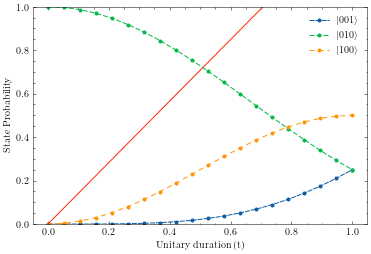

In [11]:
foo_plot(v_params, [0,0,1,0,0,0,0,0])
#foo_plot(v_params, [0,0,0,0,0,0,1,0])

final state: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


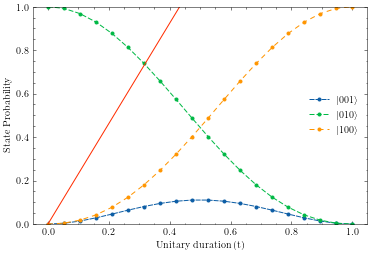

In [12]:
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
unitary = CirculatorHamiltonian.construct_U(*v_params,t=1)
# plotMatrix(unitary);
#foo_plot(v_params, [0,1/np.sqrt(2),0,1/np.sqrt(2),0,0,0,0])
foo_plot(v_params, [0,0,1,0,0,0,0,0])

In [52]:
from qiskit import transpile, BasicAer
logger.setLevel(logging.WARNING)
def foo_plot2(v_params):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        qc = QuantumCircuit(3)
        qc.x(0)
        qc.h(1)
        #qc.x(2)
        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        qc.unitary(unitary, [0,1,2])
        #qc.rz(4*np.pi/3, 1)
        #qc.s(1)
        #qc.s(2)
        qc.x(1)

        #output_state = np.matmul(unitary.full(),np.array(input_state))
        backend = BasicAer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(transpile(qc, backend)).result()
        output_state = result.get_statevector(qc)

        data.append([np.abs(el)**2 for el in output_state])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    return qc

final state: [0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999]


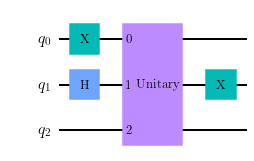

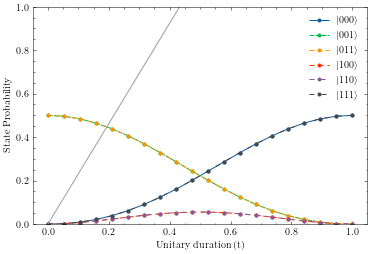

In [53]:
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
foo_plot2(v_params).draw(output='mpl')

final state: [0.0, 0.5000000000000001, 0.5000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0]


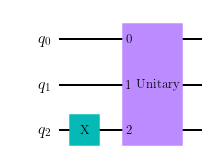

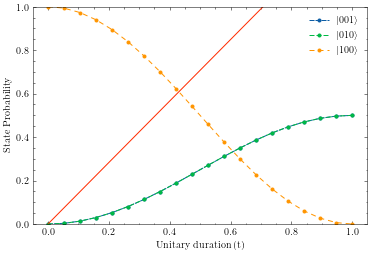

In [45]:
v_nn = 4/np.sqrt(2) #1.5iswap
phi = np.arctan(np.sqrt(2))
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
v_params = [phi, phi, 0, np.pi/v_nn, np.pi/v_nn, 0]
foo_plot2(v_params).draw(output='mpl')

final state: [0.0, 0.2222222222222222, 0.5555555555555554, 0.0, 0.22222222222222227, 0.0, 0.0, 0.0]


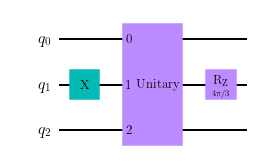

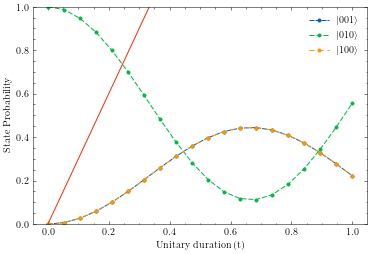

In [37]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [0, 0, 0, np.pi/2, np.pi/2, np.pi/2]
foo_plot2(v_params).draw(output='mpl')

In [30]:
qc = QuantumCircuit(3)
qc.x(1)
unitary = CirculatorHamiltonian.construct_U(*v_params,t=1)
qc.unitary(unitary, [0,1,2])
qc.rz(4*np.pi/3, 1)
qc.draw()

#qc.measure_all()
# execute the quantum circuit
from qiskit import *
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(qc, backend), shots=1000).result()
#counts  = result.get_counts(qc)
vec = result.get_statevector(qc)
#print(counts)
print(vec)
#plot_histogram(counts)

INFO:qiskit.transpiler.runningpassmanager:Pass: UnitarySynthesis - 0.00286 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: UnrollCustomDefinitions - 0.05126 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('rz', 1), ('unitary', 3)} to target basis {'id', 'x', 'barrier', 'delay', 'rz', 'snapshot', 'u3', 'sx', 'unitary', 'measure', 'u1', 'reset', 'cx', 'u2'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.001s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.transpiler.runningpassmanager:Pass: BasisTranslator - 3.58725 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.01025 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 0.02742 (ms)
INFO:qiskit.transpiler.runningpassm

[ 0.        +0.j          0.25      +0.4330127j  -0.25      +0.4330127j
  0.        +0.j         -0.35355339-0.61237244j  0.        +0.j
  0.        +0.j          0.        +0.j        ]


final state: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


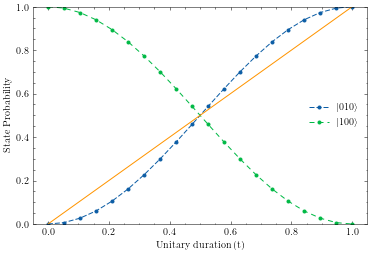

In [12]:
#make a plot that shows the state amplitude as a function of gate time
#use this plot to find input states and durations to build entangled states from the V and Delta -Swap Gates
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [0,0, 0, np.pi/2, 0, 0] #i-swap
#TODO represent states with complex values
def foo_plot(v_params, input_state):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        output_state = np.matmul(unitary.full(),np.array(input_state))
        data.append([np.abs(el)**2 for el in output_state])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
foo_plot(v_params, [0,0,0,0,1,0,0,0])
#foo_plot(v_params, [0,0,0,0,0,0,1,0])